# Numerical optimization

In [28]:
import numpy as np
from optimization_plots import plot_golden_search_problem
from optimization_algorithms import golden_search

from optimization_problems import get_nelder_mead_problem
from optimization_problems import get_golden_problem

from scipy.optimize import minimize

## Derivative-free methods

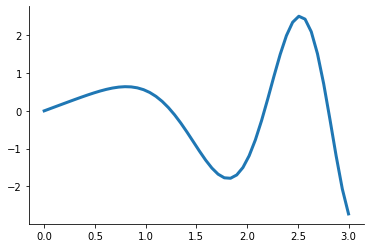

In [29]:
a, b = 0, 3
golden_search(get_golden_problem, a, b)

plot_golden_search_problem(get_golden_problem, a, b)

In [36]:
x0 = np.array([1.0, 0.0])
options = dict()
options["return_all"] = True

# Here we need to add a countour plot and add the iterates on it.
minimize(get_nelder_mead_problem, x0, options=options)

  allvecs: [array([1., 0.]), array([0.09662853, 0.45168572]), array([-0.12519053,  0.12834515]), array([-0.19655266,  0.05083954]), array([-0.19618211,  0.04642447]), array([-0.19064399,  0.04052553]), array([-0.17713179,  0.03092394]), array([-0.14794457,  0.01396595]), array([-0.08527449, -0.01684516]), array([-0.03475688, -0.03243977]), array([ 0.00720345, -0.03263856]), array([ 0.05914834, -0.01941824]), array([0.18477645, 0.0117066 ]), array([0.27967995, 0.07832235]), array([0.34533119, 0.10508519]), array([0.46353439, 0.18038021]), array([0.45795368, 0.18836326]), array([0.51400875, 0.25729295]), array([0.62039756, 0.3691665 ]), array([0.67801315, 0.4473273 ]), array([0.72842706, 0.53523275]), array([0.79766774, 0.6303247 ]), array([0.86049374, 0.72625973]), array([0.85821487, 0.72603582]), array([0.87628635, 0.76276815]), array([0.91583424, 0.83691666]), array([0.9611748 , 0.92001666]), array([0.97450013, 0.94875118]), array([0.99468653, 0.98847756]), array([0.99762531, 0.995438